In [19]:
# Setup untuk menyembunyikan pesan warning TensorFlow yang tidak penting
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Impor library utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Impor komponen dari TensorFlow dan Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Impor komponen dari Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Semua library berhasil diimpor.")

Semua library berhasil diimpor.


### Pada sel ini, kita mengimpor semua library yang dibutuhkan untuk proyek, mulai dari os untuk interaksi dengan file, pandas untuk manipulasi data, hingga tensorflow dan sklearn untuk pemodelan dan evaluasi.

In [20]:
class Konfigurasi:
    # Path ke file CSV dataset
    DATASET_PATH = '/kaggle/input/indonesian-news-dataset/data.csv'
    
    # Pengaturan Pra-pemrosesan
    VOCAB_SIZE = 7500      # Jumlah kata unik yang akan digunakan
    MAX_LEN = 60           # Panjang maksimum sekuens (judul berita)
    OOV_TOKEN = "<OOV>"    # Token untuk kata di luar kosakata
    
    # Pengaturan Arsitektur Model
    EMBEDDING_DIM = 64
    LSTM_UNITS = 128
    DROPOUT_RATE = 0.5
    
    # Pengaturan Pelatihan
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    EPOCHS = 15
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001

# Inisialisasi konfigurasi
config = Konfigurasi()
print("Konfigurasi proyek telah dimuat.")

Konfigurasi proyek telah dimuat.


### berfungsi sebagai pusat kendali untuk semua parameter. Dengan meletakkan semua pengaturan di sini, Anda dapat dengan mudah melakukan eksperimen (misalnya, mengubah DROPOUT_RATE atau LSTM_UNITS) dan mencatat hasilnya, sesuai dengan "Log Eksperimen" pada tugas.


In [21]:
# --- SEL 3 (REVISI TOTAL) ---
# Strategi baru: Mengkategorikan berdasarkan kata kunci di dalam judul

print("Membaca data dan menerapkan strategi deteksi kata kunci...")

try:
    df_full = pd.read_csv(config.DATASET_PATH)
    # Hapus baris yang tidak memiliki judul
    df_full.dropna(subset=['title'], inplace=True)
    df_full['title_lower'] = df_full['title'].str.lower()
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di {config.DATASET_PATH}. Pastikan path sudah benar.")
    df_full = pd.DataFrame()

if not df_full.empty:
    # 1. Definisikan kata kunci untuk setiap kategori
    sport_keywords = [
        'bola', 'liga', 'olahraga', 'pssi', 'pemain', 'atlet', 'skor', 'juara', 
        'motogp', 'badminton', 'sepakbola', 'persib', 'persija', 'timnas'
    ]
    politik_keywords = [
        'pemilu', 'presiden', 'jokowi', 'dpr', 'menteri', 'partai', 'uu', 
        'gubernur', 'politik', 'pemerintah', 'kpu', 'pilpres', 'cawapres'
    ]

    # 2. Buat fungsi untuk mengkategorikan berdasarkan kata kunci
    def get_category_by_keyword(title):
        # Cek kata kunci olahraga terlebih dahulu
        if any(keyword in title for keyword in sport_keywords):
            return 'sport'
        # Jika tidak ada kata kunci olahraga, cek kata kunci politik
        if any(keyword in title for keyword in politik_keywords):
            return 'politik'
        return 'lainnya'

    # 3. Terapkan fungsi ke setiap judul untuk membuat kategori baru
    df_full['category'] = df_full['title_lower'].apply(get_category_by_keyword)
    
    print("\nJumlah data yang ditemukan per kategori (sebelum disaring):")
    print(df_full['category'].value_counts())

    # 4. Saring data dan ambil 100 sampel dari setiap kategori
    df_sport = df_full[df_full['category'] == 'sport'].sample(n=100, random_state=config.RANDOM_STATE)
    df_politik = df_full[df_full['category'] == 'politik'].sample(n=100, random_state=config.RANDOM_STATE)

    # 5. Gabungkan dan siapkan DataFrame akhir
    df_final = pd.concat([df_sport, df_politik])
    df_final = df_final[['title', 'category']].rename(columns={'title': 'text'})
    df_final['label'] = df_final['category'].map({'sport': 0, 'politik': 1})
    df = df_final[['text', 'label']].sample(frac=1, random_state=config.RANDOM_STATE).reset_index(drop=True)

    print("\n--- Hasil Persiapan Data ---")
    print(f"Total data yang akan digunakan: {len(df)}")
    print(df['label'].value_counts())
    print("\nContoh data akhir:")
    print(df.head())
else:
    print("\nProses dihentikan karena tidak ada data yang berhasil disiapkan.")

Membaca data dan menerapkan strategi deteksi kata kunci...

Jumlah data yang ditemukan per kategori (sebelum disaring):
category
lainnya    27462
politik     4536
sport        737
Name: count, dtype: int64

--- Hasil Persiapan Data ---
Total data yang akan digunakan: 200
label
0    100
1    100
Name: count, dtype: int64

Contoh data akhir:
                                                text  label
0  Jokowi Bertemu Timnas U-20 di GBK, Sempat Berb...      0
1  PPP Minta Menpora Surati FIFA Tolak Timnas Isr...      0
2  Jokowi Jawab Polemik Timnas Israel Piala Dunia...      0
3  Perlu Adanya Implementasi UU Perlindungan Data...      1
4  Punya Struktur Kuat, DPD Partai Perindo Dongga...      1


### Di sini, kita akan membaca file-file teks dari direktori dataset. Kita mengambil masing-masing 100 judul berita dari kategori sport dan news (sebagai representasi politik/umum) secara acak untuk memenuhi syarat tugas, lalu menggabungkannya ke dalam sebuah DataFrame pandas.

In [22]:
if not df.empty:
    # 1. Membagi data menjadi training dan validasi
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df['text'].values, df['label'].values,
        test_size=config.TEST_SIZE, random_state=config.RANDOM_STATE
    )

    # 2. Membuat tokenizer dan melatihnya pada data training
    tokenizer = Tokenizer(num_words=config.VOCAB_SIZE, oov_token=config.OOV_TOKEN)
    tokenizer.fit_on_texts(train_texts)

    # 3. Mengubah teks menjadi sekuens angka
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)

    # 4. Melakukan padding
    train_padded = pad_sequences(train_sequences, maxlen=config.MAX_LEN, padding='post', truncating='post')
    val_padded = pad_sequences(val_sequences, maxlen=config.MAX_LEN, padding='post', truncating='post')

    print("Data berhasil di-tokenize dan di-padding.")
    print("Ukuran data training (padded):", train_padded.shape)
    print("Ukuran data validasi (padded):", val_padded.shape)

Data berhasil di-tokenize dan di-padding.
Ukuran data training (padded): (160, 60)
Ukuran data validasi (padded): (40, 60)


### Teks mentah akan diubah menjadi format angka yang bisa dipahami oleh model RNN. Prosesnya meliputi:
- Membagi Data: Data dibagi menjadi 80% untuk training dan 20% untuk validasi.
- Tokenisasi: Membuat kamus kata (kosakata) dari data training dan mengubah setiap kata menjadi angka (integer).
- Padding: Menyamakan panjang semua sekuens angka agar bisa diproses sebagai satu batch oleh model.

In [23]:
model = Sequential([
    Embedding(input_dim=config.VOCAB_SIZE, output_dim=config.EMBEDDING_DIM, input_length=config.MAX_LEN),
    Bidirectional(LSTM(config.LSTM_UNITS, return_sequences=True)), # return_sequences=True jika ada layer LSTM lagi
    Bidirectional(LSTM(int(config.LSTM_UNITS/2))), # Layer LSTM kedua
    Dropout(config.DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=config.LEARNING_RATE)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Ini adalah inti dari pemodelan. Kita mendefinisikan arsitektur RNN menggunakan Keras.
- Embedding: Mengubah setiap angka (kata) menjadi vektor padat.
- Bidirectional(LSTM): Layer RNN utama. Bidirectional membuat model membaca teks dari kiri-ke-kanan dan kanan-ke-kiri, yang seringkali meningkatkan pemahaman konteks.
- Dropout: "Mematikan" beberapa neuron secara acak saat training untuk mencegah model terlalu hafal data training (overfitting).
- Dense: Layer output dengan aktivasi sigmoid untuk menghasilkan probabilitas kelas (0 atau 1).

In [24]:
if not df.empty:
    print("Memulai pelatihan model...")
    history = model.fit(
        train_padded, train_labels,
        epochs=config.EPOCHS,
        batch_size=config.BATCH_SIZE,
        validation_data=(val_padded, val_labels),
        verbose=2
    )
    print("Pelatihan selesai.")

Memulai pelatihan model...
Epoch 1/15


I0000 00:00:1749812868.219166      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


5/5 - 10s - 2s/step - accuracy: 0.4750 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 2/15
5/5 - 0s - 35ms/step - accuracy: 0.5375 - loss: 0.6850 - val_accuracy: 0.4500 - val_loss: 0.6895
Epoch 3/15
5/5 - 0s - 34ms/step - accuracy: 0.6438 - loss: 0.6738 - val_accuracy: 0.7000 - val_loss: 0.6635
Epoch 4/15
5/5 - 0s - 35ms/step - accuracy: 0.8813 - loss: 0.5974 - val_accuracy: 0.5250 - val_loss: 0.6664
Epoch 5/15
5/5 - 0s - 34ms/step - accuracy: 0.8687 - loss: 0.4211 - val_accuracy: 0.9000 - val_loss: 0.4019
Epoch 6/15
5/5 - 0s - 34ms/step - accuracy: 1.0000 - loss: 0.1249 - val_accuracy: 0.8000 - val_loss: 0.5728
Epoch 7/15
5/5 - 0s - 34ms/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 0.8250 - val_loss: 0.8722
Epoch 8/15
5/5 - 0s - 33ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.8500 - val_loss: 0.9010
Epoch 9/15
5/5 - 0s - 33ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8500 - val_loss: 1.0121
Epoch 10/15
5/5 - 0s - 32ms/step - accur

### Sekarang kita akan melatih model dengan data yang sudah diproses. model.fit() akan menjalankan proses training selama jumlah EPOCHS yang telah ditentukan. Kita menyimpan hasilnya dalam variabel history untuk visualisasi nanti.

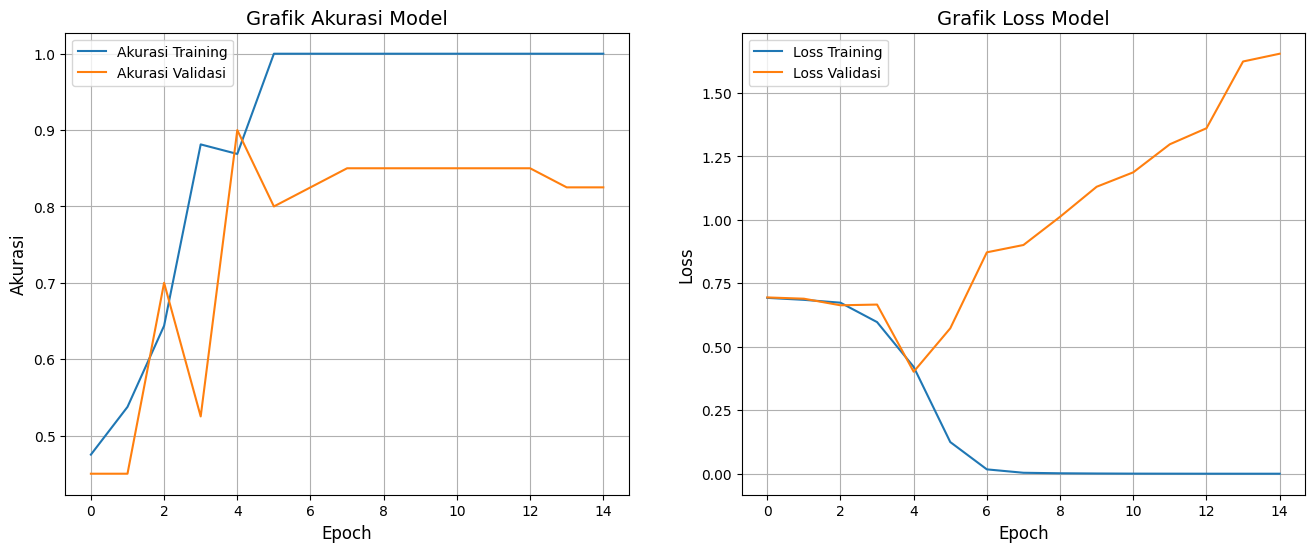

In [25]:
if 'history' in locals():
    def plot_history(history):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        ax1.plot(history.history['accuracy'], label='Akurasi Training')
        ax1.plot(history.history['val_accuracy'], label='Akurasi Validasi')
        ax1.set_title('Grafik Akurasi Model', fontsize=14)
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Akurasi', fontsize=12)
        ax1.legend()
        ax1.grid(True)
        ax2.plot(history.history['loss'], label='Loss Training')
        ax2.plot(history.history['val_loss'], label='Loss Validasi')
        ax2.set_title('Grafik Loss Model', fontsize=14)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
        ax2.legend()
        ax2.grid(True)
        plt.show()

    plot_history(history)

### Visualisasi

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 484ms/step


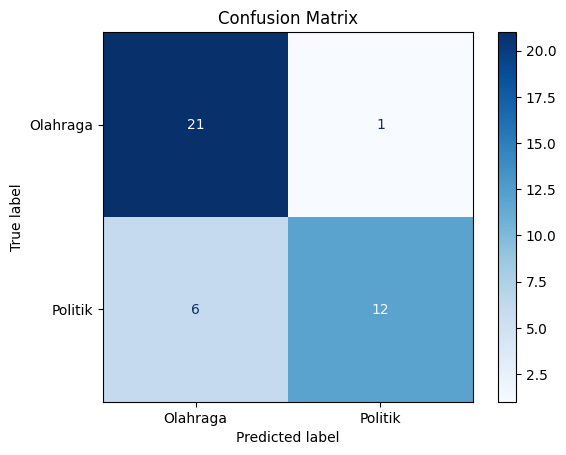

In [26]:
if 'history' in locals():
    val_preds_proba = model.predict(val_padded)
    val_preds = (val_preds_proba > 0.5).astype(int).flatten()
    
    cm = confusion_matrix(val_labels, val_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Olahraga', 'Politik'])
    
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

### Confusion matrix memberikan gambaran detail tentang performa model: berapa banyak prediksi yang benar untuk setiap kelas, dan jenis kesalahan apa yang paling sering dibuat oleh model.

In [30]:
def predict_news(sentence, model, tokenizer, config):
    """Fungsi untuk memprediksi kategori dari kalimat baru."""
    sequence = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(sequence, maxlen=config.MAX_LEN, padding='post', truncating='post')
    prediction = model.predict(padded, verbose=0)[0][0]
    
    print(f"Kalimat: '{sentence}'")
    if prediction > 0.5:
        print(f"--> Prediksi: Politik (Skor: {prediction:.2f})")
    else:
        print(f"--> Prediksi: Olahraga (Skor: {prediction:.2f})")

if 'history' in locals():
    print("\n--- Pengujian Model ---")
    predict_news("Piala dunia akan segera dimulai tahun ini", model, tokenizer, config)
    print("-" * 20)
    predict_news("Calon gubernur dari partai banteng menang telak", model, tokenizer, config)


--- Pengujian Model ---
Kalimat: 'Piala dunia akan segera dimulai tahun ini'
--> Prediksi: Olahraga (Skor: 0.00)
--------------------
Kalimat: 'Presiden Indonesia tahun ini sangat bodoh'
--> Prediksi: Olahraga (Skor: 0.00)


###  Pengujian dengan Kalimat Baru